In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
combined_faces_zip_path = "/content/drive/MyDrive/Copy of combined_faces.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [ ]:
combined_faces_zip_path = "/content/drive/MyDrive/Copy of combined_faces_train_augmented.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
train_aug_df = pd.read_csv("/content/drive/MyDrive/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("/content/drive/MyDrive/images_filenames_labels_test.csv")

In [ ]:
train_aug_df.head()

,filename,age
0,/content/content/combined_faces_train_augmente...,43
1,/content/content/combined_faces_train_augmente...,71
2,/content/content/combined_faces_train_augmente...,6
3,/content/content/combined_faces_train_augmente...,18
4,/content/content/combined_faces_train_augmente...,25


In [ ]:
test_df.head()

,filename,age
0,/content/content/combined_faces/8_163.jpg,8
1,/content/content/combined_faces/38_66.jpg,38
2,/content/content/combined_faces/40_177.jpg,40
3,/content/content/combined_faces/36_267.jpg,36
4,/content/content/combined_faces/8_349.jpg,8


In [ ]:
train_aug_df.shape

(234400, 2)

In [ ]:
test_df.shape

(10046, 2)

In [ ]:
def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
train_aug_df.head()

,filename,age,target
0,/content/content/combined_faces_train_augmente...,43,4
1,/content/content/combined_faces_train_augmente...,71,6
2,/content/content/combined_faces_train_augmente...,6,1
3,/content/content/combined_faces_train_augmente...,18,2
4,/content/content/combined_faces_train_augmente...,25,3


In [ ]:
test_df.head()

,filename,age,target
0,/content/content/combined_faces/8_163.jpg,8,1
1,/content/content/combined_faces/38_66.jpg,38,4
2,/content/content/combined_faces/40_177.jpg,40,4
3,/content/content/combined_faces/36_267.jpg,36,4
4,/content/content/combined_faces/8_349.jpg,8,1


In [ ]:
train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [ ]:
num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(512)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)

In [ ]:
final_cnn = Sequential()

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(GlobalAveragePooling2D())
final_cnn.add(Dense(132, activation='relu'))
final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 128)      

In [ ]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs")

In [ ]:
checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [ ]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


Training Loss: [1.8195174932479858, 1.607426404953003, 1.422432541847229, 1.3026520013809204, 1.3435674905776978, 1.1373732089996338, 1.0538381338119507, 1.000543236732483, 0.9592428207397461, 0.9187482595443726, 0.8836166858673096, 0.8587939739227295, 0.831487238407135, 0.8074319958686829, 0.7838466763496399, 0.7595197558403015, 0.7349963188171387, 0.7164477705955505, 0.6901683807373047, 0.6697328090667725, 0.6539376974105835, 0.6392786502838135, 0.6211065053939819, 0.6046997904777527, 0.5932087898254395, 0.5790726542472839, 0.555234432220459, 0.5336841940879822, 0.5151488780975342, 0.4993703365325928]
Test Loss: [1.610352873802185, 1.4848076105117798, 1.3439472913742065, 1.2250441312789917, 1.1689022779464722, 1.109602928161621, 1.019425630569458, 1.0061830282211304, 0.9247558116912842, 0.8922168016433716, 0.8651857972145081, 0.8473340272903442, 0.8478729128837585, 0.8435403108596802, 0.786843478679657, 0.767827570438385, 0.7682989835739136, 0.7289084196090698, 0.7061796188354492, 0.

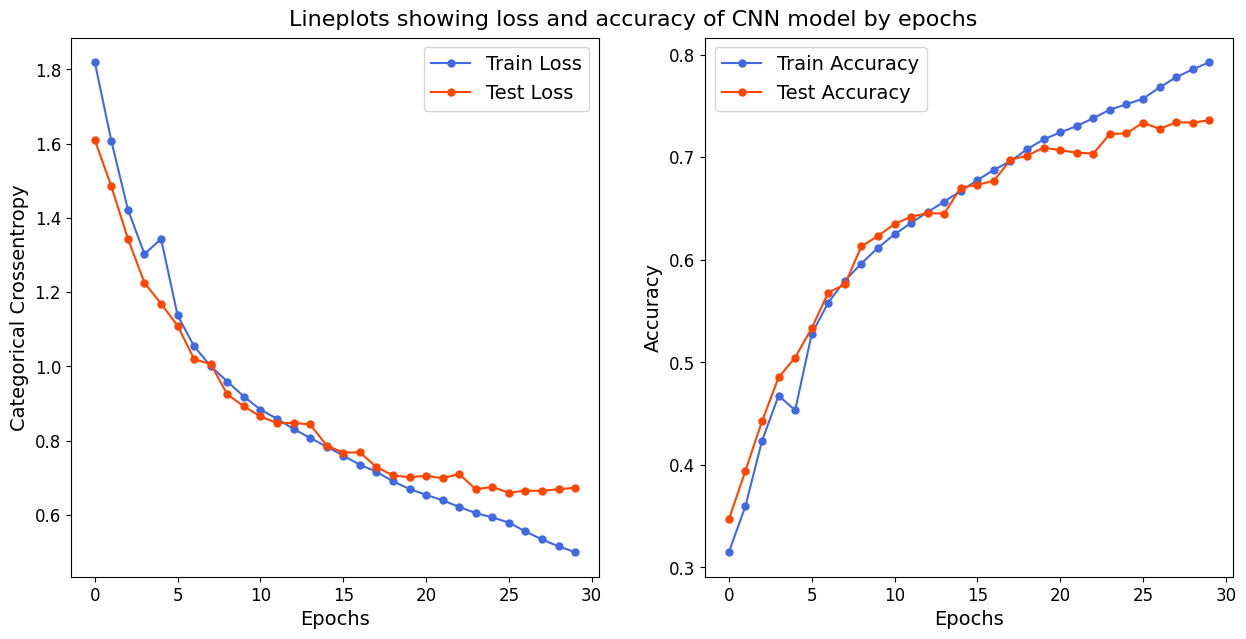

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

plt.savefig('/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

In [ ]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 3s 134ms/step - loss: 0.6729 - accuracy: 0.7359


In [ ]:
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

CNN model loss 		= 0.673
CNN model accuracy 	= 0.736


In [ ]:
final_cnn.save(f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

In [ ]:
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

20/20 [==============================] - 5s 259ms/step


In [ ]:
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)
conf_mat

array([[ 869,   77,    0,    3,    8,    0,    1],
       [  31,  756,   30,   11,   13,    1,    3],
       [   1,   91,  611,   98,  137,    2,    1],
       [   3,    7,   76,  976,  922,   19,    4],
       [   4,    6,   29,  224, 2336,  197,   11],
       [   1,    3,    6,    9,  347, 1167,  146],
       [   2,    1,    2,    3,   18,  105,  678]])

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    plt.savefig(f'/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


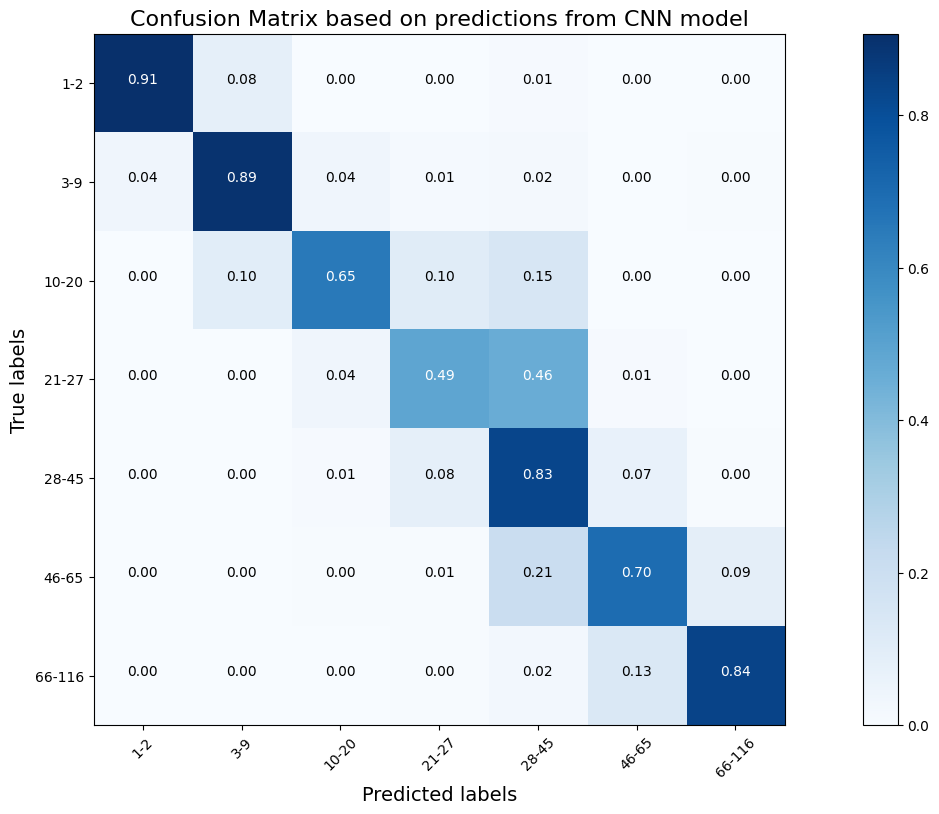

In [ ]:
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()